In [1]:
%load_ext autoreload
%autoreload 2
"""
    Some imports used throughout the notebook
"""
import time
import cpmpy
from visualize import *

from cpmpy.transformations.normalize import toplevel_list
from cpmpy.tools.explain import make_assump_model
from factory import *
from read_data import get_data
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.set_printoptions(linewidth=90)
# preload solvers
from cpmpy import SolverLookup
names = SolverLookup.solvernames()

import networkx as nx
import re
draw = lambda g,**kwargs : nx.draw_circular(g, width=5, node_size=500,**kwargs)
cmap = ["black", "yellow", "cyan", "lightgreen", "blue"]

def graph_highlight(graph, cons, dotted=False, **kwargs):
    edges = []
    for c in cons:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        edges.append((a,b))
        
    colors = ["red" if (a,b) in edges else "black" for (a,b) in graph.edges()]
    linestyles = ["dotted" if c == "red" and dotted else "solid" for c in colors]
    return draw(graph, edge_color=colors, style=linestyles, **kwargs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-03


## Explainable Constraint Solving - A Hands-On Tutorial @ ECAI-2024
### Ignace Bleukx, Dimos Tsouros, Tias Guns

#### KU Leuven, Belgium

<p>&nbsp;</p>

<table><tr style="background: white;">
    <td>&nbsp;</td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/kul.jpg" width=45%></td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/tuples_logo.jpeg" width=45%></td>
    <td style="text-align: center; vertical-align: middle;"><img src="img/erc.jpg" width=45%></td>
</tr></table>

<!-- Thanks to Bart Bogaerts, Emilio Gamba and Jo Devriendt -->


<small>This presentation is an executable Jupyter notebook</small>

Link to slides and more examples: https://github.com/CPMpy/XCP-explain


## Constraint Solving

<img src="img/solutions_vizual.png" width="45%" align="right" style="margin-top:100px">

Solving combinatorial optimization problems in AI

- Vehicle Routing

- Scheduling

- Manufacturing

- Other combinatorial problems ...

## Model + Solve

<center><img src="img/prob2sol.png" width=70%></center>

- What if no solution is found?
- What if the user does not _like_ the solution?
- What if the user _expected_ a different solution?
- ...


## Trustworthy & Explainable constraint solving

Human-aware AI:

- Respect human _agency_
- _Support_ users in decision making
- Provide explanations and learning opportunities

Acknowledges that a 'model' is only an approximation of the full problem,<br />
that it might result in _undesirable_ solutions.

## Hands-on Explainable Constraint Programming (XCP)


### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB; &#9194;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB; 
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<center><img src="img/interaction_figure4.png" width=20%></center>


<!-- Can be combined in interactive systems:
  - _Iteratively refine explanation & model_ -->

## Explaining constraint 'propagation'?

Concept from Lazy Clause Generation / CP-SAT solvers (Stuckey, 2010)

"every time a propagator determines a domain change of a variable,<br>
it records a **clause** that _explains_ the domain change."

- _someone_: one propagator
- _something_: a clause (disjunction of literals)
- to _someone_: a SAT solver, not a person

#### We focus on <b>user-oriented explanations</b> involving multiple constraints.

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<img src="img/interaction_figure4.png" width=20% align="right">

- **Deductive explanation:**
  - _What constraints cause X?_
- **Counterfactual explanation**:
  - _What to change if I want Y instead of X?_


<!-- Can be combined in interactive systems:
  - _Iteratively refine explanation & model_ -->

### Then what?

<img src="img/interaction_figure4.png" width="20%" align="left" style="margin:5%;"/>

1. User is happy with the answer <br>
    (e.g. better understands the problem)
2. User changes the answer and uses that <br>
    (solution interaction; no solver involvement)
3. User changes the model and reiterates <br>
    (e.g. better understands how to model the problem)
4. User interacts with interactive system <br>
    (e.g. conversational explanations)



# Example XCP interaction

Toy example, graph coloring:

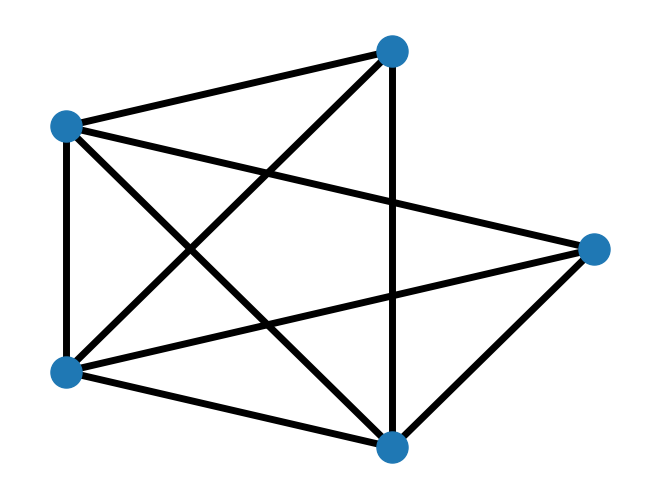

In [2]:
G = nx.fast_gnp_random_graph(5, 0.8, seed=0)
draw(G)

Assigning colors to the nodes of a graph, such that no two _adjacent_ nodes share the same color,c and the number of colors is minimized.

(real example: assign each booking request (node) to a room (color) such that no temporally overlapping requests use the same room)

# Modeling Minimum Graph Coloring as a CP problem

* Decision variables:<br> $x_i \in \{1..\text{max_colors}\} \quad \forall i \in \{1..N\}$
* Constraints:<br> $x_i \neq x_j \quad \forall (i,j) \in \text{Edges}$
* Objective:<br> minimize $max(x)$

In [3]:
def graph_coloring(G, max_colors=None):
    n = G.number_of_nodes()
    if max_colors is None:
        max_colors = n  # upper bound: all distinct
    
    x = cp.intvar(1, max_colors, shape=n, name="x")
    m = cp.Model(
        [x[i] != x[j] for i,j in G.edges()],
        minimize=cp.max(x)
    )
    return m, x

## Multiple high-level constraint programming languages exist

We will use the CPMpy modeling library in Python for this presentation

<center><img src="img/cpmpy-intro.png" style="max-width: 70%;" /></center>


## The system: http://cpmpy.readthedocs.io

CPMpy is a Constraint Programming and Modeling library in Python, <br /> based on numpy, with direct solver access. <br /> 

**Language**:
- Boolean and Integer variables
- Logical and Arithmetic constraints
- 'Global Constraints' (AllDifferent, Cumulative, Element, Abs, Max, Min, ...)
- Arbitrary nesting and reification of expressions

**Features** used in this tutorial:

- Easy integration with visualisation tools (pandas, matplotlib)
- Object-oriented programming (constraints are Python objects we can create, copy, update)
- Repeatedly solving subsets of constraints (assumption variables)
- Incremental solving (e.g. SAT, MIP/Hitting set)



## Solver-independent modeling library

Incremental solving (&amp; transformations):

<center><img src="img/cpmpy_transformations.png" style="max-width: 70%;" /></center>

## Solvers available in CPMpy (Oct 2024)

| **Solver** | **Technology** | **Installation** | **Assumption variables?** | **Notes**|
|------------|----------------|------------------|---------------------------|----------|
| **Z3**     | SMT            | pip              | Yes                       |          |
| **Or-Tools** | CP-SAT       | pip              | Yes                | Assumptions NOT incremental! Every solve starts from scratch |
| **Choco**  | CP             | pip              | No                        |          |
| **Gurobi** | ILP            | pip + (aca.) license | No                    |          |
| **Exact**  | Pseudo-Boolean | pip (only Linux, Win(py>3.10))   | Yes      | Manual installation on Mac possible |
| **PySAT**  | SAT            | pip              | Yes                       | Only Boolean variables (CPMpy implementation incomplete)

Or-Tools is the default solver and automatically installed when you pip install CPMpy.

Our rule-of-thumb when *solving* a problem: OrTools > Gurobi > Exact > Others

Our rule-of-thumb when *explaining* a problem: Exact > Z3 > OrTools > Others

# Modeling Minimal Graph Coloring as a CP problem

### Lets color the graph...

ExitStatus.OPTIMAL (0.003024 seconds)
Found optimal coloring with 4 colors


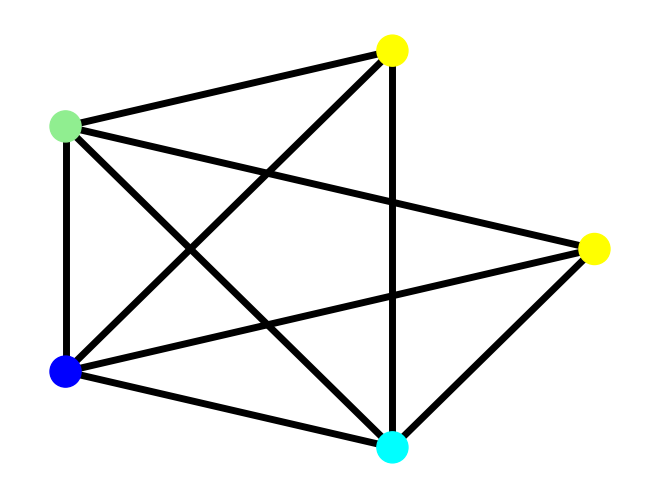

In [4]:
m, nodes = graph_coloring(G, max_colors=None)
if m.solve():
    print(m.status())
    print(f"Found optimal coloring with {m.objective_value()} colors")
    draw(G, node_color=[cmap[v.value()] for v in nodes])
else:
    print("No solution found.")

# Example XCP interaction

Found optimal coloring with 4 colors


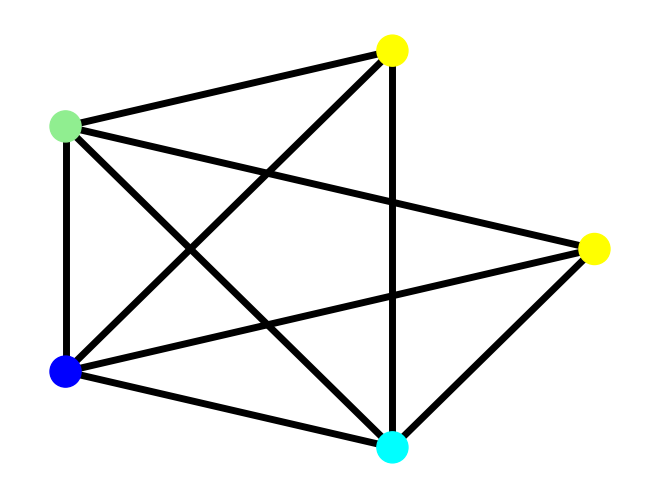

In [5]:
print(f"Found optimal coloring with {m.objective_value()} colors")
draw(G, node_color=[cmap[n.value()] for n in nodes])

<img src="img/why.png" width="15%" align="left" style="margin-top:-40px; margin-right:50px; margin-left: 300px">
yes... but why do we need 4? 

# Example XCP interaction

## _Why_ do we need at least 4 colors?

**Deductive** explanation: pinpoint to constraints _causing_ this fact

UNSAT is caused by the following constraint(s):


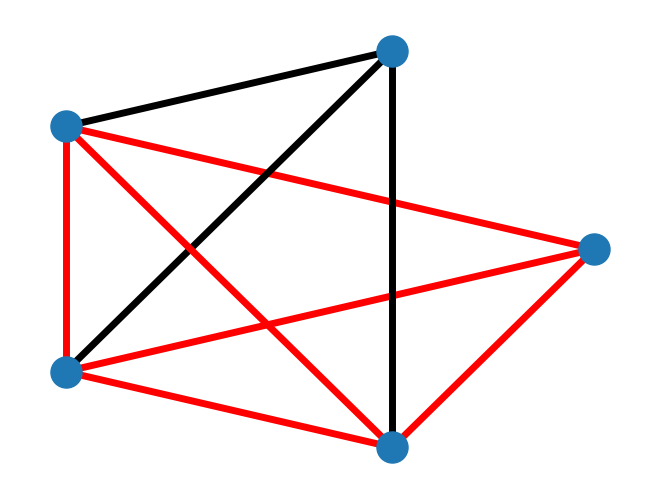

In [6]:
from cpmpy.tools.explain import mus

m, nodes = graph_coloring(G, max_colors=3)  # less than 4?

if m.solve() is False:
    conflict = mus(m.constraints)  # Minimal Unsatisfiable Subset
    print("UNSAT is caused by the following constraint(s):")
    graph_highlight(G, conflict)

# Example XCP interaction

## _Why_ do we need at least 4 colors?

**Counterfactual** explanation: pinpoint to constraint *changes* that would allow, e.g. 3 colors

UNSAT can be resolved by removing the following constraint(s):


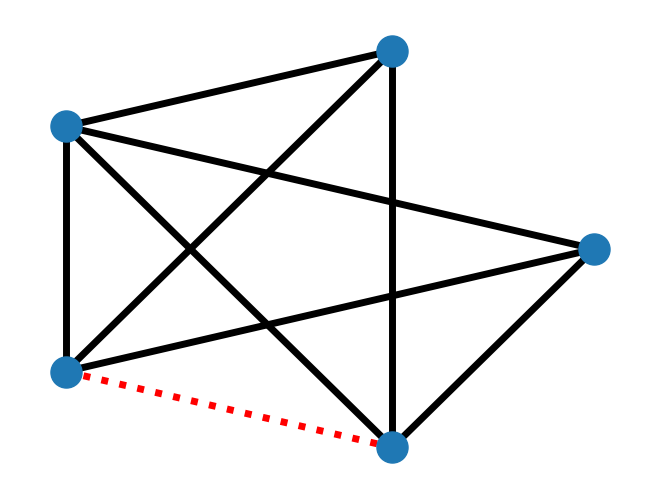

In [7]:
from cpmpy.tools.explain import mcs

m, nodes = graph_coloring(G, max_colors=3)  # less than 4?

if m.solve() is False:    
    corr = mcs(m.constraints)  # Minimal Correction Subset
    print("UNSAT can be resolved by removing the following constraint(s):")
    graph_highlight(G, corr, dotted=True)

# Example XCP interaction

## _Why_ do we need 4 colors?

**Counterfactual** explanation: pinpoint to constraint *changes* that would allow, e.g. 3 colors

Can now compute the counterfactual solution:

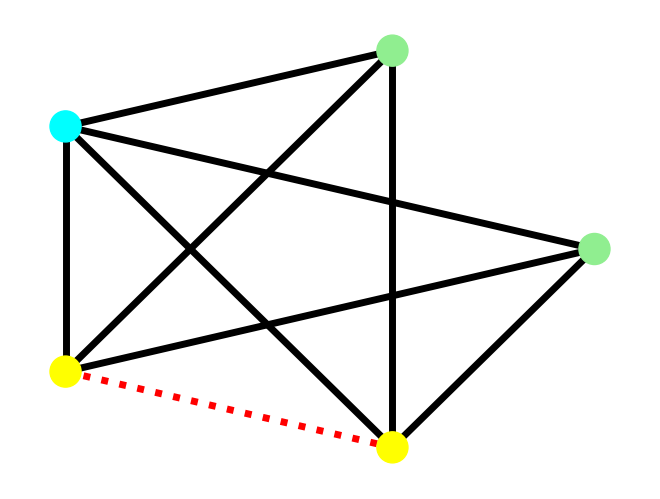

In [8]:
# compute and visualise counter-factual solution
m2 = cp.Model([c for c in m.constraints if c not in corr])
m2.solve()
graph_highlight(G, corr, node_color=[cmap[n.value()] for n in nodes], dotted=True)

# Applications of explanation techniques

> "Sudoku Assistant–an AI-Powered App to Help Solve Pen-And-Paper Sudokus", AAAI-2023 Best Demo Award, Tias Guns, Emilio Gamba, Maxime Mulamba, Ignace Bleukx, Senne Berden, and Milan Pesa.

<center><img src="img/app_explanations.png"  style="max-width: 80%;"></center>

# Applications of explanation techniques

> "Human-centred feasibility restoration in practice", CP 2021, Ilankaikone Senthooran, Gleb Belov, Kevin Leo, Michael Wybrow, Matthias Klapperstueck, Tobias Czauderna, Mark Wallace, and Maria Garcia De La Banda.

<center><img src="img/plant_layout_expl.png"  style="max-width: 80%;"></center>

# Applications of explanation techniques

> "Trustworthy and Explainable Decision-Making for Workforce Allocation", CP 2024 PTHG workshop, Guillaume Povéda, Andreas Strahl, Mark Hall, Ryma Boumazouza, Santiago Quintana-Amate, Nahum Alvarez, Ignace Bleukx, Dimos Tsouros, Hélène Verhaeghe, Tias Guns.

Workforce allocation (e.g. moving airplane parts in an Airbus factory site)

<center><img src="img/task_alloc_expl.png"  style="max-width: 80%;"></center>

### Relation to Explainable AI (XAI) at large

#### D. Gunning, 2015: DARPA XAI challenge
"Every explanation is set within a context that depends..." <!-- on the task, abilities, and expectations of the user of the AI system." --> -> domain dependent

#### M. Fox et al, 2017: Explainable Planning

Need for trust, interaction and transparancy.

#### T. Miller, 2018: Explainable AI: Beware of Inmates Running the Asylum

Insights from the social sciences: _Someone_ explains _something_ to _someone_

#### R. Guidotti, 2018: A survey of methods for explaining black box ML models

The vast majority of work/attention...

## Formal XAI

**J. Marques-Silva, A. Ignatiev, AAAI-2022: Delivering Trustworthy AI through Formal XAI**

... best known XAI approaches (in ML) fail to provide sound explanations or exhibit significant redundance ...

"Formal explanations are not only sound but guarantee irredundancy."

$ $

**All formal XAI methods** relate back to two crucial concepts and related meta-algorithms:

* Minimal Unsatisfiable Subset (MUS)
* Minimal Correction Subset (MCS)

What conceptually changes is the **set of what**...

## Formal XAI

**All formal XAI methods** relate back to two crucial concepts and related meta-algorithms.

What conceptually changes is the **set of what** (and the solvers underneath):

### In Constraint Solving: [Liffiton et al, 2008]

* Deductive Explanations: e.g. Minimal Unsatisfiable Subset **of constraints**
* Contrastive Explanations: e.g. Minimal Correction Subset **of constraints**

### In Machine Learning [Marques-Silva et al, 2022]

* Abductive Explanations (AXp's), PI-explanations, sufficient reasons: e.g. Minimal Unsatisfiable Subset **of feature assignments**

* Contrastive Explanations (CXp's): e.g. Minimal Correction Subset **of feature assignments**

### In Planning: [Eiffler et al, 2020]

* Minimal Unsatisfiable Subset **of unsolvable goals**
* Minimal Correction Subset **of unsolvable goals**


## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

### hospital constraints:

<img src="img/nurse_rost_prob.jpg" align="right">

* nb of shifts required on each day
* max nb of shifts per nurse
* max nb of weekend shifts
* min/max consecutive shifts

### nurse constraints / preferences:

* specific days off-duty
* specific shift requests (on/off)

## Running example in this talk: Nurse Scheduling

* The assignment of _shifts_ and _holidays_ to nurses.
* Each nurse has their own restrictions and preferences,
    as does the hospital.

In [9]:
instance = "Benchmarks/Instance1.txt"  # "http://www.schedulingbenchmarks.org/nrp/data/Instance1.txt"
data = get_data(instance)

## Nurse Rostering: data

Instances from http://www.schedulingbenchmarks.org/

"benchmark test instances from various sources including industrial collaborators and scientific publications."

<!-- 7 types of hospital constraints, 2 types of nurse constraints -->

In [10]:
print("Nr of days to schedule:", data.horizon)
print("Nr of shift types:", len(data.shifts))

print("Staff holidays:")
pd.merge(data.days_off, data.staff[["# ID","name"]], left_on="EmployeeID", right_on="# ID", how="left")

Nr of days to schedule: 14
Nr of shift types: 1
Staff holidays:


,EmployeeID,DayIndex,# ID,name
0,A,0,A,Megan
1,B,5,B,Katherine
2,C,8,C,Robert
3,D,2,D,Jonathan
4,E,9,E,William
5,F,5,F,Richard
6,G,1,G,Kristen
7,H,7,H,Kevin


In [11]:
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_optimization_model()  # CPMpy model with all constraints

model.solve(solver="ortools")
visualize(nurse_view.value(), factory)  # live decorated dataframe

## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB; &#9194; 

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


## Hands-on: exploring graph coloring explanations

https://github.com/CPMpy/XCP-explain

Notebook: ecai2024_practice_part1.ipynb

(also through Google Colab, no installation needed!)

## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#9194; &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


# Deductive explanations

_What constraints cause X?_

Explain _why_ X is a logical consequence of (part of) the input.

E.g.,
- _why_ is there no solution
- _why_ does an assignment follow from the constraints
- _..._

All these cases can typically be reduced to explaining UNSAT.

Example, explain why _fact_ follows from constraints _C_:

$\quad\quad C \models \mathit{fact} \quad\Leftrightarrow\quad C \wedge \neg \mathit{fact} \models \bot$

## Nurse rosterering, explaining unsatisfiability


<img src="img/explain_unsat.png" width="15%" align="left" style="margin:50px;">

* Model nurse rostering problem as decision problem <br>
    (no objective)
        
* Nurse **preferences** are also hard constraints

In [12]:
# model as decision model
factory = NurseSchedulingFactory(data)
model, nurse_view = factory.get_decision_model()  # CMPpy DECISION Model
model.solve()

False

... no solution found

In [13]:
print(f"Model has {len(model.constraints)} constraints:")
for cons in model.constraints: print("-", cons)

Model has 360 constraints:
- Megan can work at most 14 D-shifts
- Katherine can work at most 14 D-shifts
- Robert can work at most 14 D-shifts
- Jonathan can work at most 14 D-shifts
- William can work at most 14 D-shifts
- Richard can work at most 14 D-shifts
- Kristen can work at most 14 D-shifts
- Kevin can work at most 14 D-shifts
- Megan cannot work more than 4320min
- Katherine cannot work more than 4320min
- Robert cannot work more than 4320min
- Jonathan cannot work more than 4320min
- William cannot work more than 4320min
- Richard cannot work more than 4320min
- Kristen cannot work more than 4320min
- Kevin cannot work more than 4320min
- Megan should work at least 3360min
- Katherine should work at least 3360min
- Robert should work at least 3360min
- Jonathan should work at least 3360min
- William should work at least 3360min
- Richard should work at least 3360min
- Kristen should work at least 3360min
- Kevin should work at least 3360min
- Megan can work at most 5 days bef

## Deductive Explanations for UNSAT problems

The set of all constraints is unsatisfiable.

<img src="img/allcons.png" width="20%" float="right" style="margin:50px;">


But do all constraints contribute to this?

## Deductive Explanations for UNSAT problems

### Minimal Unsatisfiable Subset (MUS)

<img src="img/mus.png" width="20%" align="left" style="margin:50px;">

Pinpoint to constraints causing a conflict

... trim model to a minimal set of constraints

... minimize cognitive burden for user


### How to compute a MUS?

Deletion-based MUS algorithm

_[Joao Marques-Silva. Minimal Unsatisfiability: Models, Algorithms and Applications. ISMVL 2010. pp. 9-14]_

In [14]:
def mus_naive(constraints):
    m = cp.Model(constraints)
    assert m.solve() is False, "Model should be UNSAT"
    
    core = constraints
    i = 0
    while i < len(core):
        print(f"\rCurrent core size = {len(core)}, leaving out:", core[i], end="\t"*5)
        subcore = core[:i] + core[i+1:]
        if cp.Model(subcore).solve():
            i += 1 # removing makes it SAT, need to keep
        else:
            core = subcore # can safely delete 
    print()
    return core

### How to compute a MUS?

Deletion-based MUS algorithm

<img src="img/order_delmus.png" width="85%">


### How to compute a MUS, <u>efficiently</u>?

In [15]:
t0 = time.time()
core = mus_naive(model.constraints)
print(f"Naive MUS took {time.time()-t0} seconds")

Current core size = 4, leaving out: Shift D on Sun 2 must be covered by 4 nurses out of 8															
Naive MUS took 88.81146597862244 seconds


In [16]:
from cpmpy.tools.explain import mus

t0 = time.time()
core = mus(model.constraints, solver="exact")
print(f"Assumption-based MUS took {time.time()-t0} seconds")

Assumption-based MUS took 2.5320019721984863 seconds


### How to compute a MUS, <u>efficiently</u>?

In [17]:
def mus_assum(constraints, solver="ortools"):
    # add indicator variable per expression
    constraints = toplevel_list(constraints, merge_and=False)
    assump = cp.boolvar(shape=len(constraints), name="assump")  # Boolean indicators
    m = cp.Model(assump.implies(constraints))  # [assump[i] -> constraints[i] for all i]
    
    s = cp.SolverLookup.get(solver, model)
    assert s.solve(assumptions=assump) is False, "Model should be UNSAT"

    core = s.get_core()  # start from solver's UNSAT core of assumption variables
    i = 0
    while i < len(core):
        subcore = core[:i] + core[i+1:]  # try all but constraint 'i'
        if s.solve(assumptions=subcore) is True:
            i += 1  # removing 'i' makes it SAT, need to keep for UNSAT
        else:
            core = subcore
    return [c for c,var in zip(constraints,assump) if var in core]

### How to compute a MUS, <u>efficiently</u>?

<center><img src="img/mus_assum.png" style="max-width: 85%;" /></center>

### How to compute a MUS, <u>efficiently</u>?

Assumption-based incremental solving **only for Boolean SAT** problems?

<b>No!</b>

* SMT solvers: <i>SAT Module Theories with CDCL</i> (e.g. Z3)
* CP-solvers: <i>Lazy Clause Generation</i> (e.g. OR-Tools)
* Pseudo-Boolean solvers: <i>Conflict-Driven Cutting Plane Learning</i> (e.g. Exact)
* MaxSAT solvers: <i>Core-guided solvers</i>

### Running example

MUS explanation of why the nurse rostering instance is UNSAT


In [18]:
from cpmpy.tools.mus import mus

solver = "ortools" # change to "exact" for incremental
subset = mus(model.constraints, solver=solver) 

print("Length of MUS:", len(subset))
for cons in subset: print("-", cons)

Length of MUS: 11
- Robert requests to work shift D on Wed 1
- Richard has a day off on Sat 1
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Robert requests to work shift D on Thu 1
- Robert can work at most 5 days before having a day off
- Kevin should work at most 1 weekends
- Robert requests to work shift D on Mon 1
- Robert requests to work shift D on Tue 1
- Kevin requests to work shift D on Sat 2
- Katherine has a day off on Sat 1
- Robert requests to work shift D on Fri 1


## Running example

MUS explanation of why the nurse rostering instance is UNSAT

In [19]:
visualize_constraints(subset, nurse_view, factory)

### Many MUS'es may exist...

_Liffiton, M.H., & Malik, A. (2013). Enumerating infeasibility: Finding multiple MUSes quickly. In
Proceedings of the 10th International Conference on Integration of AI and OR Techniques in Constraint
    Programming (CPAIOR 2013) (pp. 160–175)_

In [20]:
from cpmpy.tools.explain import marco

solver = "ortools"  # default solver
if "exact" in cp.SolverLookup.solvernames(): solver = "exact"  # fast for increment solving

t0 = time.time()
cnt = 0
for (kind, sset) in marco(model.constraints, solver=solver, map_solver=solver):
    if kind == "MUS":
        print("M", end="")
        cnt += 1
    else: print(".", end="") # MSS
    
    if time.time() - t0 > 15:  break  # for tutorial: break after 15s
print(f"\nFound {cnt} MUSes in", time.time() - t0)


MMMMMMMMMMMMMMMMMMMMMMMMM.MMMMMMMMMM.MM.MMMMMMMMM..MMMMMMMMMMMMMMMM..MMMMM.MMMMMM.M.MM..MMMMM.MMMMMMMM..MMM.M..M.M.MMM.MMM.MMM.MMMMMMMM..MM
Found 114 MUSes in 15.011045694351196


### Many MUS'es may exist...

<img src="img/musses.png" width="40%" align="left" style="margin-left:50px; margin-right:50px">

This problem has just 360 constraints, yet 100.000+ MUSes exist...

Which one to show? 

Can we influence which MUS is found?

## Influencing which MUS is found?

<b>QuickXPlain algorithm</b> <i>(Junker, 2004)</i>.
Widely used, in model-based diagnosis, recommender systems, verification, and more.

Divide-and-conquer given a lexicographic <i>preference</i> order over the constraints:

$c_1 < c_2 < c_3 < ... < c_n$ (= have as few 'right-most' as possible)

In [21]:
# the order of 'soft' matters! lexicographic preference for the first ones
def quickxplain_naive(soft, hard=[], solver="ortools"):
    model, soft, assump = make_assump_model(soft, hard)
    s = cp.SolverLookup.get(solver, model)
    assert s.solve(assumptions=assump) is False, "The model should be UNSAT!"

    # the recursive call
    def do_recursion(tocheck, other, delta):
        print("@", end="")
        if len(delta) != 0 and s.solve(assumptions=tocheck) is False:
            # conflict is in hard constraints, no need to recurse
            return []

        if len(other) == 1:
            # conflict is not in 'tocheck' constraints, but only 1 'other' constraint
            return list(other)  # base case of recursion

        split = len(other) // 2  # determine split point
        more_preferred, less_preferred = other[:split], other[split:]  # split constraints into two sets

        # treat more preferred part as hard and find extra constants from less preferred
        delta2 = do_recursion(tocheck + more_preferred, less_preferred, more_preferred)
        # find which preferred constraints exactly
        delta1 = do_recursion(tocheck + delta2, more_preferred, delta2)
        return delta1 + delta2

    core = do_recursion([], list(assump), [])
    dmap = dict(zip(assump, soft))
    return [dmap[a] for a in core]


## Influencing which MUS is found?

<b>QuickXPlain</b>: Divide-and-conquer given a lexicographic <i>preference</i> order over the constraints:

&nbsp;

<center><img src="img/quickxplain.png" style="max-width: 70%;" /></center>

## Running example

<b>QuickXPlain algorithm</b> <i>(Junker, 2004)</i>.
Widely used, in model-based diagnosis, recommender systems, verification, and more.

Divide-and-conquer given a lexicographic order over the constraints

In [22]:
from cpmpy.tools.explain import quickxplain

t0 = time.time()
subset = quickxplain_naive(sorted(model.constraints, key=lambda c: -len(str(c))), solver="ortools")  # prefer complex constraints
print("\nPrefer complex (long len(str)) constraints: Length of MUS:", len(subset))
print(f"(in {time.time()-t0} seconds)")

t0 = time.time()
subset = quickxplain_naive(sorted(model.constraints, key=lambda c: len(str(c))), solver="ortools")  # prefer short constraints
print("\nPrefer short len(str) constraints: Length of MUS:", len(subset))
print(f"(in {time.time()-t0} seconds)")

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Prefer complex (long len(str)) constraints: Length of MUS: 39
(in 11.042917013168335 seconds)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Prefer short len(str) constraints: Length of MUS: 3
(in 2.0805091857910156 seconds)


Best algorithm when you have a non-incremental solver! (logarithmic nr solve calls)

## Finding a _smallest_ or _weighted smallest_ MUS?

Give every constraint a weight: OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>.

An extension of the **implicit hitting-set approach** for finding _smallest_ MUSes <i>(Ignatiev, Janota, Marques-Silva, 2014)

<br>

**Key properties we will need**:

1. If a subset is SAT, can <i>grow</i> it to a Maximal Satisfiable Subset (MSS)
2. The complement of a MSS is a Minimal Correction Subset (MCS)
3. Theorem: A MUS is a hitting set of the MCSes (= covers at least 1 constraint in every MCS)

<table><tr>
    <td width=10%>
        <center><img width=60% src="img/mcs.png" /></center>
    </td> 
    <td width=10%>
        <center><img width=60% src="img/hittingset.png" /></center>
    </td>
</tr></table>

## Optimising which MUS is found?

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraints has a weight.

1. Initialize sets-to-hit $\mathcal{H}$   (e.g. insert one set of all constraints)
2. Find *optimal* hitting set $S$
3. Check if SAT: grow and take complement = MCS $K$, add to sets-to-hit $\mathcal{H}$
4. Repeat until UNSAT: optimal unsatisfiable subset $S$ found

<center><img src="img/smus.png" width=55% /></center>

## <u>Efficiently</u> optimising which MUS is found?

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraints has a weight.

&nbsp;

<center><img src="img/smus_efficient.png" width=65%/></center>

## Running example, nurse rostering

OUS: Optimal Unsatisfiable Subsets <i>(Gamba, Bogaerts, Guns, 2021)</i>. Every constraint has a weight.

In [23]:
from cpmpy.tools.explain import optimal_mus

sat_solver = "exact" if "exact" in names else "ortools" # incremental SAT solver
hs_solver = "gurobi" if "gurobi" in names else "ortools" # incremental MIP solver

small_subset = optimal_mus(model.constraints, solver=sat_solver, hs_solver=hs_solver)

print("Length of sMUS:", len(small_subset))
for cons in small_subset:  
    print("-", cons)

Length of sMUS: 3
- Robert has a day off on Tue 2
- Richard requests not to work shift D on Tue 2
- Shift D on Tue 2 must be covered by 7 nurses out of 8


In [24]:
visualize_constraints(small_subset, nurse_view, factory)

## Step-wise explanation

<img src="img/explain_step-wise.png" width="20%" align="right" style="margin:50px;">

- We were lucky, the SMUS is pretty understandable
- What if its not?
- Split a large MUS into smaller steps <br>
  -> Step-wise Explanations

> Ignace Bleukx, Jo Devriendt, Emilio Gamba, Bart Bogaerts, Tias Guns. Simplifying Step-wise Explanation Sequences. 29th International Conference on Principles and Practice of Constraint Programming (CP23), 2023.

## Step-wise explanations

Step-wise explanations originally proposed for explaining *satisfiable* problems (the unique solution or maximal consequence).

> Bogaerts, Bart, Emilio Gamba, and Tias Guns. "A framework for step-wise explaining how to solve constraint satisfaction problems." Artificial Intelligence 300 (2021): 103550.

&nbsp;

### Example: step-wise explaining a Sudoku assignment

<center><img src="img/stepwise.png" /></center>

## Step-wise explanations

**Sudoku**
- Step derives assignment
- Stop at full assignment (solution)

**UNSAT**
- Step derives invalid assignments
- Stop when domain is empty

## Step-wise explanations

- $C$: set of all constraints
- $I$: set of literals
- $f$: cost function
- $\texttt{propagate}(C)$: full propagation  

$\texttt{Explain-One-Step}$: 

find optimal MUS for each remaining literal 

($C \wedge \neg l$)

Select optimal one amongst the all of them

<img src="img/stepwise_pseudo.png" width="40%" align="right" style="margin-top:-600px;">

## Step-wise explanations for any target

Risk on redundancy in sequence

<center><img src="img/stepwise.png" /></center>

Need filtering and __simplification__ in post-processing

>Ignace Bleukx, Jo Devriendt, Emilio Gamba, Bart Bogaerts, Tias Guns. Simplifying Step-wise Explanation Sequences. 29th International Conference on Principles and Practice of Constraint Programming (CP23), 2023.

### Any MUS

In [25]:
subset = mus(model.constraints)

visualize_constraints(subset, nurse_view, factory)

### Let's find a sequence of step-wise explanations of this MUS

In [26]:
from explanations.stepwise import find_sequence

seq = find_sequence(subset)

Found sequence of length 11
Filtered sequence to length 11


In [27]:
nurse_view.clear()
visualize_step(seq[0], nurse_view, factory)

Propagating constraint: Kevin requests to work shift D on Sat 2


In [28]:
visualize_step(seq[1], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Tue 1


In [29]:
visualize_step(seq[2], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Fri 1


In [30]:
visualize_step(seq[3], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Thu 1


In [31]:
visualize_step(seq[4], nurse_view, factory)

Propagating constraint: Richard has a day off on Sat 1


In [32]:
visualize_step(seq[5], nurse_view, factory)

Propagating constraint: Kevin should work at most 1 weekends


In [33]:
visualize_step(seq[6], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Mon 1


In [34]:
visualize_step(seq[7], nurse_view, factory)

Propagating constraint: Robert requests to work shift D on Wed 1


In [35]:
visualize_step(seq[8], nurse_view, factory)

Propagating constraint: Robert can work at most 5 days before having a day off


In [36]:
visualize_step(seq[9], nurse_view, factory)

Propagating constraint: Shift D on Sat 1 must be covered by 5 nurses out of 8


In [37]:
visualize_step(seq[10], nurse_view, factory)

Propagating constraint: Katherine has a day off on Sat 1


## Recap: deductive explanations

MUS = Minimal Unsatisfiable Subset

| **Algorithm**           | **Characteristics**                                                                                                                                  | **First solver call**                | **Subsequent calls**                | **Efficiency**                                                              |
|-------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|---------------------------------------|------------------------------------------------------------------------------|
| **Deletion-based MUS**   | Trivial to implement, arbitrary MUS                                                            | All constraints except one     | Linear decrease                       | Efficient for assumption-based incremental solvers.                           |
| **QuickXplain**          | Optional lexicographic preference over constraints.                                                                       | Half the constraints (n/2)     | Divide and conquer                  | Reasonably efficient for non-incremental solvers.                             |
| **sMUS/OUS**             | Guaranteed smallest/optimal US. One weight per constraint.                                       | One constraint                 | Slow increase                       | Only calls solver with small subsets of constraints.            |

## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB; &#9194; 
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


## Hands-on: exploring graph coloring explanations

https://github.com/CPMpy/XCP-explain

Notebook: ecai2024_practice_part2.ipynb

(also through Google Colab, no installation needed!)

## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (Diagonis, Max-CSP, MCS, Slack-based relaxation) &#9194; &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


## Explainable Constraint Programming (XCP)

Recap, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

<img src="img/coloring_mus.png" width=25% align="right">

- **Deductive explanation:**
  - _What constraints cause X?_
  - answer: a minimal inference set

<img src="img/coloring_mcs.png" width=25% align="right">

- **Counterfactual explanation**:
  - _What to change if I want Y instead of X?_
  - answer: a constraint relaxation + new solution

## Resolving conflicts: _"What to change if I want a solution instead of UNSAT?"_

First idea: iteratively resolve each conflict

Diagnosis: *interactively* computing and resolving conflicts

> Reiter, Raymond. "A theory of diagnosis from first principles." Artificial intelligence 32.1 (1987): 57-95.

## Interactive conflict resolution

In [38]:
def diagnose_naive(soft, hard=[], solver="ortools"):
    
    cons = set(soft)
    while cp.Model(list(cons) + hard).solve(solver=solver) is False:
        subset = mus(soft=list(cons), hard=hard, solver=solver)  # find conflict
        print("Constraints in subset")
        for i,c in enumerate(subset):
            print(f"{i}. {c}")
        idx = int(input("Which one to remove? "))
        # resolve conflict
        cons.remove(subset[idx])
        clear_output()

## Interactive conflict resolution

In [39]:
start_interactive_mode = False

if start_interactive_mode:
    def cb_visu(core): 
        clear_output(), display(visualize_constraints(core, nurse_view, factory))

    from explanations.diagnosis import diagnose, diagnose_optimal
    corr_subset = diagnose(model.constraints, solver="exact", callback=cb_visu)
    clear_output()
    print("Resolved.")

## Counterfactual explanation of an UNSAT problem

<img src="img/fixing_mcs.png" width="20%" align="left" style="margin:50px;">

How to **change the model**, in order to find a solution?

Previous approach may require many iterations...

AND user only has __local__ information, global resolution may be sub-optimal

Instead, directly find subset of _soft constraints_ to **remove** <br> 

## Counterfactual explanation of an UNSAT problem

<img src="img/fixing_mcs.png" width="20%" align="left" style="margin:50px;">

How to **change the model**, in order to find a solution?

Previous approach may require many iterations...

AND user only has __local__ information, global resolution may be sub-optimal

Instead, directly find subset of _soft constraints_ to **remove** <br> 

Find __optimal__ set to remove

This is textbook Max-CSP solving!

### Max-CSP solving

$\mathit{maximize} \sum w_i \cdot b_i$

$st. b_i \implies c_i$

<img src="img/mcs.png" width="40%" align="right" style="margin-top:-100px;">



In [40]:
indicators = cp.boolvar(shape=len(model.constraints), name="ind")
ind_model = cp.Model(indicators.implies(model.constraints))
ind_model.maximize(indicators.sum())

assert ind_model.solve() is True
print(f"Found optimal solution with {ind_model.objective_value()} out of {len(ind_model.constraints)} constraints")

Found optimal solution with 356 out of 360 constraints


In [41]:
print("Removed these constraints:")
for c in model.constraints:
    if c.value() is False:
        print("-", c)
        
print("Resulting solution:")
visualize(nurse_view.value(), factory)

Removed these constraints:
- Robert has a day off on Tue 2
- Richard requests not to work shift D on Tue 2
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Shift D on Sun 1 must be covered by 5 nurses out of 8
Resulting solution:


### Max-CSP solving

Finds an __optimal__ correction subset

BUT may be hard to compute (e.g., stuck proving optimality)

Instead, find non-optimal, but minimal correction subset, fast


### How to compute a Minimal Correction Subset of an UNSAT problem?

<img src="img/mcs.png" width="20%" align="left" style="margin:50px;">


Grow-based MCS/MSS

* Start from the empty (satisfiable) set

* Grow the satisable subset by adding one constraint at a time

* Each constraint that causes UNSAT is in the MCS

### Grow-based MCS

In [42]:
def mcs_naive(constraints):
    mss = []  # grow a satisfiable subset one-by-one
    mcs = []  # everything else is in the minimum conflict set
    
    for cons in constraints:
        if cp.Model(mss + [cons]).solve():
            mss.append(cons)  # adding it remains SAT
        else:
            mcs.append(cons)  # UNSAT, causes conflict
    
    return mcs

### Grow-based MCS

In [43]:
from cpmpy.tools.explain import mcs  # using assumption variables

corr_subset = mcs(model.constraints)

print("By removing these constraints, the model becomes SAT:")
for cons in corr_subset: print("-",cons)
    
visualize_constraints(corr_subset, nurse_view, factory)

By removing these constraints, the model becomes SAT:
- Shift D on Sun 1 must be covered by 5 nurses out of 8
- Shift D on Sat 1 must be covered by 5 nurses out of 8
- Richard requests not to work shift D on Tue 2
- Robert has a day off on Tue 2


In [44]:
mss = set(model.constraints) - set(corr_subset)
        
corrected_model = cp.Model(list(mss))
assert corrected_model.solve()

print(f"Counterfactual solution: ({len(corr_subset)} fewer constraints)")
visualize(nurse_view.value(), factory)

Counterfactual solution: (4 fewer constraints)


### Influencing which MCS is found?

* Lexicographic order over constraints: FastDiag is the MCS counterpart of QuickXplain

> A. Felfernig, M. Schubert, and C. Zehentner. An efficient diagnosis algorithm for inconsistent constraint sets. AI EDAM, 26(1):53–62, 2012.
  

In [45]:
# the order of 'soft' matters! lexicographic preference for the first ones
def fastdiag_naive(soft, hard=[], solver="ortools"):
    model, soft, assump = make_assump_model(soft, hard)
    s = cp.SolverLookup.get(solver, model)
    assert s.solve(assumptions=assump) is False, "The model should be UNSAT!"

    # the recursive call
    def do_recursion(tocheck, other, delta):
        print("@", end="")
        if len(tocheck) != 0 and s.solve(assumptions=delta):
            # constraints without tocheck is satisfiable, no need to recurse over other
            return []

        if len(other) == 1:
            # only 1 'other' constraint remaining to search over
            return list(other)  # base case of recursion

        split = len(other) // 2  # determine split point
        more_preferred, less_preferred = other[:split], other[split:]  # split constraints into two sets

        # treat more preferred part as hard and find extra constraints in less preferred
        delta1 = do_recursion(more_preferred, less_preferred, [c for c in delta if c not in set(more_preferred)])
        # find which more preferred constraints exactly
        delta2 = do_recursion(delta1, more_preferred, [c for c in delta if c not in set(delta1)])
        return delta1 + delta2

    mcs = do_recursion([], list(assump), list(assump))
    dmap = dict(zip(assump, soft))
    return [dmap[a] for a in mcs]

Let's find an MCS with _short_ constraints

In [46]:
t0 = time.time()
subset = fastdiag_naive(sorted(model.constraints, key=lambda c: len(str(c))), solver="ortools")  # prefer short constraints
print("\nPrefer short len(str) constraints: Length of MCS:", len(subset))
print(f"(in {time.time()-t0} seconds)")
visualize_constraints(subset, nurse_view, factory)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Prefer short len(str) constraints: Length of MCS: 12
(in 2.756643056869507 seconds)


### How to compute a Minimal Correction _Subset_ of an UNSAT problem?

A minimal correction **subset** corrects an unsatisfiable problem by **dropping** constraints.

If each constraint is a clause, that is probably the best you can do...

$ $

For rich applications, like nurse rostering, there is often a softer **degree of violation**

In [47]:
visualize_constraints(mcs(model.constraints), nurse_view, factory)

E.g. from requiring 5 nurses on Saturday and Sunday to requiring 0 nurses is **pretty drastic**...

### How to compute a Minimal Correction of an UNSAT problem?

Requires defining **corrective actions**, e.g. constraint violations that allows for *relaxations* of constraints.

E.g. **feasbility restoration** by modifying rather then removing constraints

> Senthooran I, Klapperstueck M, Belov G, Czauderna T, Leo K, Wallace M, Wybrow M, Garcia de la Banda M. Human-centred __feasibility restoration__ in practice. Constraints. 2023 Jul 20:1-41.

### Types of relaxations of constraints:

<img src="img/slack.png" width="20%" align="right" style="margin:20px;">

* Boolean constraints: can only be turned on/off
* Numerical constraints: can be __violated__ to some extend
  * Introduce slack for each numerical constraint
  * Slack indicates how much a constraint may be violated
    * = fine grained penalty of solution
  * Minimize (weighted) aggregate of slack values

## Running example, nurse rostering

### Slack-based relaxations

<img src="img/slack.png" width="10%" align="right" style="margin:20px;">

E.g., allow violation of _cover constraints_ (nr of nurses on a specific day)<br>
    --> Allow days to be *slightly* under/overstaffed

In [48]:
# slack variables can only be positive here (separate over and under relaxation)
slack_under = cp.intvar(0, len(data.staff), shape=data.horizon, name="slack_under")
slack_over = cp.intvar(0, len(data.staff), shape=data.horizon, name="slack_over")

for _, cover in factory.data.cover.iterrows():
    # read the data
    day = cover["# Day"]
    shift = factory.shift_name_to_idx[cover["ShiftID"]]

    nb_nurses = cp.Count(nurse_view[:, day], shift)
    # deviation of `nb_nurses` from `requirement`
    expr = (nb_nurses == cover["Requirement"] - slack_under[day] + slack_over[day])

## Running example, nurse rostering

### Minimize global violation

In [49]:
slack_model, slack_nurse_view, slack_under, slack_over = factory.get_slack_model()  # CMPpy Model

slack = cp.cpm_array(np.append(slack_under, slack_over))
slack_model.minimize(cp.sum(slack_under) + cp.sum(slack_over)) # minimize global violation

# visualize
assert slack_model.solve()
style = visualize(slack_nurse_view.value(), factory, highlight_cover=True)
style.data.loc["Slack under"] = list(slack_under.value()) + [" "," "]
style.data.loc["Slack over"] = list(slack_over.value()) + [" ", " "]
display(style)

## Running example, nurse rostering

### Slack-based relaxations

Minimize nb of non-zero slacks constraints (similar to the MAX-CSP approach)

In [50]:
slack_model.minimize(cp.sum(slack != 0)) # minimize nb of violated constraints
 
assert slack_model.solve()
style = visualize(slack_nurse_view.value(), factory, highlight_cover=True)
style.data.loc["Slack under"] = list(slack_under.value()) + [" "]*2
style.data.loc["Slack over"] = list(slack_over.value()) + [" "]*2
display(style)

## Running example, nurse rostering

### Slack-based relaxations

Or minimize any combination

In [51]:
obj1 = cp.max(slack)       # minimize max violation
obj2 = cp.sum(slack != 0)  # minimize nb of violations
obj3 = cp.sum(slack)       # minimize global violation

slack_model.minimize(10000 * obj1 + 1000 * obj2 + obj3) # multi-objective optimization

assert slack_model.solve()
style = visualize(slack_nurse_view.value(), factory, highlight_cover=True)
style.data.loc["Slack under"] = list(slack_under.value()) + [" "]*2
style.data.loc["Slack over"] = list(slack_over.value()) + [" "]*2
display(style)

## Recap: counterfactual explanations for UNSAT

MCS = Minimal Correction Subset

| **Algorithm**           | **Characteristics**                                                                                                                                  | **First solver call**                | **Subsequent calls**                | **Efficiency**                                                              |
|-------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|---------------------------------------|------------------------------------------------------------------------------|
| **Grow-based MCS**   | Trivial to implement, arbitrary MCS                                                            | One constraint     | Linear increase                       | Efficient for assumption-based incremental solvers.                           |
| **FastDiag**          | Optional lexicographic preference over constraints.                                                                       | Half the constraints (n/2)     | Divide and conquer                  | Reasonably efficient for non-incremental solvers.                             |
| **Max-CSP**             | Optimal, e.g. weight per constraint                 | Reified constraints                 | /                       | Reified formulation can be more difficult to solve            |
| **Slack-based COP**     | Optimal, define slack-based relaxation for every constraint | Relaxed constraints   | / | Adding slack decision variables can be more difficult to solve


## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB; &#9194;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


## Hands-on: exploring graph coloring explanations

https://github.com/CPMpy/XCP-explain

Notebook: ecai2024_practice_part2.ipynb

(also through Google Colab, no installation needed!)

## Outline of the tutorial

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and Pareto-optimal solutions &#9194;
- Deductive explanations (UNSAT-based)
- Counterfactual explanations (UNSAT-based, inverse optimization) &#x1F4BB;

### Part 4: Outlook and Q&A


## Explaining Optimization problems

- Model uses hard constraints and soft constraints
    - Not all constraints can be satisfied, some of them (preferences) are modeled as _soft constraints_
    - Put fine grained penalty on violation of _soft constraints_ based on their importance
- Given objective: minimize **penalty of unsatisfied preferences**
- Objective may contain subobjectives
- Subobjectives/types of preferences in nurse rostering
    - shift requests on,
    - shift requested off,
    - cover constraints

In [52]:
model, nurse_view = factory.get_optimization_model()

assert model.solve()
opt_sol = nurse_view.value()
opt_value = model.objective_value()
  
display(visualize(opt_sol, factory))
print("Total penalty:", model.objective_value())
print("Time to calculate:", model.status().runtime, "s")

Total penalty: 607
Time to calculate: 0.11250900000000001 s


## Multiple solutions

- User not satisfied with optimal solution?

- There could be multiple optimal solutions

- Find (a subset of) them by converting to a decision problem
    - Enforcing the optimal objective value

- Use `solveAll()`

In [53]:
opt_model = cp.Model(model.constraints) # init new model
opt_model += (model.objective_ == model.objective_value()) # force objective

opt_model.solveAll(solver="ortools", solution_limit=3,
                   display=lambda: display(visualize(nurse_view.value(), factory)))  # callback that visualizes sols

3

## Multiple non-dominated solutions

- User not satisfied with optimal solution?

- Optimize again, considering non-dominated solutions based on sub objectives!
    - Non-dominated solution: No other solution will be better (lower penalty) on all objectives...

- There could be multiple non-dominated solutions -> with different trade-offs!!

3 different objectives in nurse rostering:

      - Penalty on positive shift requests

      - Penalty on negative shift requests

      - Penalty of the cover constraints


In [54]:
# Find non-dominated solutions --
model, nurse_view, penalty_on, penalty_off, penalty_cover = factory.get_multi_objective_model()

objectives = [penalty_on, penalty_off, penalty_cover] # penalty_on, penalty_off, penalty_cover are the 3 subobjectives
 
solutions_limit = 10
solutions = []
solution_images = []

while len(solutions) < solutions_limit:
    model.solve() # find solution
    model += cp.any([obj < obj.value() for obj in objectives])  # dominance constraint
    solutions.append(nurse_view.value())
    solution_images.append([obj.value() for obj in objectives])

for s in solutions:
    display(visualize(s, factory))


In [55]:
# Create a DataFrame from the solution_images list
solutions_df = pd.DataFrame(
    solution_images,
    columns=['Penalty On', 'Penalty Off', 'Penalty Cover']
)

display(solutions_df)

,Penalty On,Penalty Off,Penalty Cover
0,3,3,601
1,4,3,600
2,3,5,600
3,2,8,600
4,3,0,701
5,4,0,700
6,2,4,700
7,2,3,701
8,1,4,701
9,1,6,700


## Hands-on Explainable Constraint Programming (XCP)

<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;

### Part 3: Explaining Optimization problems
- Multi-objective optimization and pareto-optimal solutions
- Deductive explanations &#9194;
- Counterfactual explanations &#x1F4BB;

### Part 4: Outlook and Q&A

## Deductive explanation for optimization problems

<img src="img/why_not_better.png" width="20%" align="right" style="margin:50px;">

#### Why is there no **even better** solution?

What constraints **causes** that there is no better solution?

- Reduce to UNSAT problem:

  - Add better-than-optimal objective value as constraint: $C \wedge (f(x) < o) \models \bot$

- Then use deductive explanations for UNSAT!


### Graph colouring problem:

Cannot find better solution due to the following constraint(s):


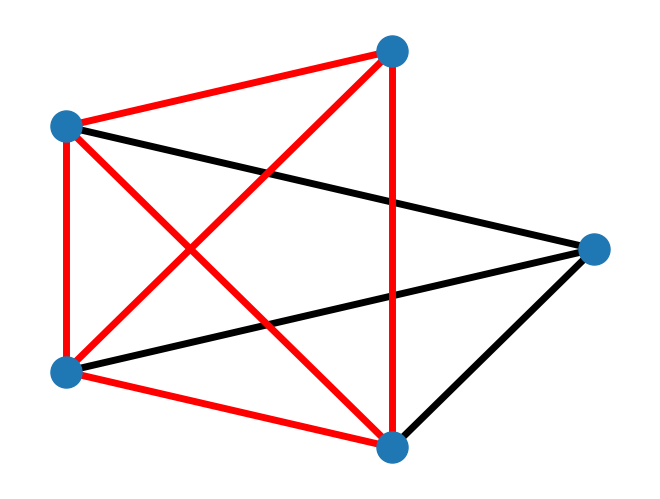

In [56]:
m, nodes = graph_coloring(G)  # back to graph colouring
m.solve()
m += (m.objective_ < m.objective_value())

if m.solve() is False:
    conflict = mus(m.constraints) # Minimal Unsatisfiable Subset
    print("Cannot find better solution due to the following constraint(s):")
    graph_highlight(G, conflict)

### Nurse rostering problem

In [57]:
model, nurse_view = factory.get_optimization_model()
model.solve() # find optimal solution

dmodel = cp.Model(model.constraints)
dmodel += (model.objective_ < model.objective_value())

assert dmodel.solve() is False
t0 = time.time()
core = mus(dmodel.constraints, solver="exact")
print(len(core))
print(f"(in {time.time()-t0} seconds)")
visualize_constraints(core, nurse_view, factory)

100
(in 99.74227571487427 seconds)


Can use the step-wise explanation techniques to explain why it is now UNSAT!

> Bleukx, I., Devriendt, J., Gamba, E., Bogaerts B., & Guns T. (2023). Simplifying Step-wise Explanation Sequences. In International Conference on Principles and Practice of Constraint Programming 2023

**Challenges**
 
- How to deal with redundancy in the sequence? 
    - _I.e., how to decide what information is relevant to derive?_
- Simplify to interpretable sequences?
    - Few and small steps 
- How to make the algorithm incremental?
    - _I.e., how to find good sequences fast?_

## Hands-on Explainable Constraint Programming (XCP)

<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;


### Part 3: Explaining Optimization problems
- Multi-objective optimization and pareto-optimal solutions
- Deductive explanations
- Counterfactual explanations &#9194; &#x1F4BB;

### Part 4: Outlook and Q&A

## Counterfactual explanation for optimization problems

<img src="img/why_not_better.png" width="20%" align="right" style="margin:50px;">

#### Why is there no **even better** solution?


What **to change** if I want a better solution?

- Reduce to UNSAT problem:

  - Add better-than-optimal objective value as constraint: $C \wedge (f(x) < o) \models \bot$

- Then use counterfactual explanations for UNSAT!


In [58]:
from cpmpy.tools.explain import mcs

# Find best solution
model.solve()

# Convert to UNSAT
constraints = model.constraints
hard_con = (model.objective_ < model.objective_value())
opt_model = cp.Model(model.constraints)
opt_model += hard_con

assert opt_model.solve() is False
t0 = time.time()
corr_subset = mcs(constraints, hard=hard_con)
print(len(corr_subset))
print(f"(in {time.time()-t0} seconds)")
visualize_constraints(corr_subset, nurse_view, factory)


1
(in 0.729107141494751 seconds)


Compute and visualise counter-factual solution

In [59]:
opt_model2 = cp.Model([c for c in model.constraints if c not in set(corr_subset)])
opt_model2.minimize(model.objective_)

assert opt_model2.solve() is True
display(visualize(nurse_view.value(), factory))
print("Total penalty:", model.objective_value())

Total penalty: 306


## Counterfactual explanations for optimization problems

#### What if I want Y in my solution instead of X? &#8592; Changing the solutions or our model

Our model is based on the problem definition &#8594; which is an <b>approximation of our problem</b>! <br>
\- can have undesirable solutions <br>
\- due to preferences or constraints not given to the model

  
<center><img src="img/prob2sol.png" width=70%></center>

## Counterfactual explanations for optimization problems

<img src="img/changing_solution.png" width="20%" align="right" style="margin:50px;">

#### What if I want Y in my solution instead of X? &#8592; Changing the solution
        
How to (optimally) change the solution having Y instead of X? 

<b>Y is a foil</b>: a partial assignment or constraint that is counter-factual &#8594; different from the returned solution.

Need to solve $C + Y$, with $C$ the (original) set of constraints and $Y$ the foil

* Case 1: $C + Y$ is SAT &#8594; May result in less optimal objective value <br>
\- Show new (changed) solution to the user <br>
\- Along with resulting penalty

* Case 2: $C + Y$ is UNSAT: <br>
\- counterfactual explanation of why the foil leads to UNSAT



In [60]:
# Find optimal solution
model.solve()
opt_sol = nurse_view.value()
opt_value = model.objective_value()

display(visualize(opt_sol, factory))

Robert __does not__ want to work on 1st saturday

In [61]:
Y = nurse_view[2,5] == 0 # The foil is that Robert does not want to work on 1st saturday
mmodel = model.copy()
mmodel += Y 

assert mmodel.solve()
print("Total penalty:", mmodel.objective_value(), "was:", opt_value)

Total penalty: 608 was: 607


In [62]:
style = highlight_changes(nurse_view.value(), opt_sol, factory)
display(style)

## Counterfactual explanations for optimization problems

<img src="img/changing_solution.png" width="20%" align="right" style="margin:50px;">

#### What if I want Y in my solution instead of X? &#8592; Limited changes to last solution
        
- Previous solution is very different from original! <br>
    &#8594; Do not want to change everyone's schedule!

- Change only a few parts of it?

- Tradeoff between difference and penalty



In [63]:
mmodel += cp.sum(nurse_view != opt_sol) <= 5 # allow to make 5 changes
assert mmodel.solve()
print("Total penalty:", mmodel.objective_value(), "was:", opt_value)

style = highlight_changes(nurse_view.value(), opt_sol, factory)
display(style)

Total penalty: 707 was: 607


## Counterfactual explanations for optimization problems

<img src="img/change_model.png" width="20%" align="right" style="margin:50px;">

#### What if I want Y in my solution instead of X? &#8592; Changing the optimization model

- "Why not Y" &#8594; "Under <b>what conditions</b> would Y be optimal?"
        
- _Given_: model with linear objective function $w*c$, <br>and a 'foil' Y (constraints to satisfy in optimal)<br>
- _Find_: new objective function weights $w'$<br> such that optimal solution satisfies $Y$
        
- Explains necessary **changes to the model**<br> &#8594; rather than the solution!

> [Korikov, Anton, and J. Christopher Beck. "Counterfactual explanations via inverse constraint programming." In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021).]

## Counterfactual explanations for optimization problems

#### What if I want Y in my solution instead of X? &#8592; Changing the optimization model
Find currently optimal solution $X$:

In [64]:
model, nurse_view = factory.get_optimization_model()

assert model.solve()
print("Total penalty: ", model.objective_value())
visualize(nurse_view.value(), factory)

Total penalty:  607


## Counterfactual explanations: changing the optimisation model

Robert is unhappy!

In [65]:
nurse = "Robert"
 
for (w,pref) in zip(*model.objective_.args):
    if nurse in str(pref):
        print('\033[1m' if pref.value() else '\033[0m', f"{pref.value()} \t Penalty:{w} \t{pref} \t")

 False 	 Penalty:1 	Deny Robert's request to work shift D on Mon 1 	
 False 	 Penalty:1 	Deny Robert's request to work shift D on Tue 1 	
 False 	 Penalty:1 	Deny Robert's request to work shift D on Wed 1 	
 True 	 Penalty:1 	Deny Robert's request to work shift D on Thu 1 	
 True 	 Penalty:1 	Deny Robert's request to work shift D on Fri 1 	
 False 	 Penalty:1 	Deny Robert's request not to work shift D on Sat 2 	
 False 	 Penalty:1 	Deny Robert's request not to work shift D on Sun 2 	


In [66]:
desc = "Deny Robert's request to work shift D on Fri 1"
weight,d_on_fri1 = next((w,pref) for w,pref in zip(*model.objective_.args) if str(pref) == desc)
print(f"{d_on_fri1.value()} \t Penalty:{weight} \t{d_on_fri1}")

True 	 Penalty:1 	Deny Robert's request to work shift D on Fri 1


## Counterfactual explanations: changing the optimisation model

Robert's request to work on Fri 1 is very important! His daughter has a surgery that day.

How should he minimally change _his_ preferences for that?

In [67]:
foil = {d_on_fri1 : False}  # don't want to have his request for Fri 1 denied!
print("Foil:", foil)
print("\n")

other_prefs = [(w,pref) for w,pref in zip(*model.objective_.args) if nurse in str(pref) and str(pref) != desc]
print(f"{nurse}'s other preferences:")
for w,pref in other_prefs:
    print("- Penalty",w,":",pref)

Foil: {roster[2,4] != 1: False}


Robert's other preferences:
- Penalty 1 : Deny Robert's request to work shift D on Mon 1
- Penalty 1 : Deny Robert's request to work shift D on Tue 1
- Penalty 1 : Deny Robert's request to work shift D on Wed 1
- Penalty 1 : Deny Robert's request to work shift D on Thu 1
- Penalty 1 : Deny Robert's request not to work shift D on Sat 2
- Penalty 1 : Deny Robert's request not to work shift D on Sun 2


## Counterfactual explanations: changing the optimisation model

Algorithmically, it is a beautiful inverse optimisation problem with a multi-solver main/subproblem algorithm

<img src="img/inverse_opt.png" width="90%" align="right" style="margin:50px;">


In [68]:
from explanations.counterfactual import inverse_optimize

ov = model.objective_value()
new_obj = inverse_optimize(model=model, minimize=True,
                           user_sol = foil,
                           allowed_to_change = set(p[1] for p in other_prefs))
print(f"Done! Found solution with total penalty {new_obj.value()}, was {ov}\n")

# Let's look at the preferences he should enter, to work on Fri 1!
print(f"{nurse}'s new preferences:")
for w,pref in zip(*new_obj.args):
    if nurse in str(pref):
        print('\033[1m' if w != 1 else '\033[0m', f"Penalty",w,":",pref)

Done! Found solution with total penalty 608, was 607

Robert's new preferences:
 Penalty 1 : Deny Robert's request to work shift D on Mon 1
 Penalty 1 : Deny Robert's request to work shift D on Tue 1
 Penalty 1 : Deny Robert's request to work shift D on Wed 1
 Penalty 2 : Deny Robert's request to work shift D on Thu 1
 Penalty 1 : Deny Robert's request to work shift D on Fri 1
 Penalty 1 : Deny Robert's request not to work shift D on Sat 2
 Penalty 1 : Deny Robert's request not to work shift D on Sun 2


In [69]:
# compute and visualize new solution
model.minimize(new_obj)
assert model.solve()
print("Total penalty: ", model.objective_value())
visualize(nurse_view.value(), factory)

Total penalty:  608


In [70]:
nurse = "Robert"
 
for (w,pref) in zip(*model.objective_.args):
    if nurse in str(pref):
        print('\033[1m' if pref.value() else '\033[0m', f"{pref.value()} \t Penalty:{w} \t{pref} \t")

 False 	 Penalty:1 	Deny Robert's request to work shift D on Mon 1 	
 False 	 Penalty:1 	Deny Robert's request to work shift D on Tue 1 	
 False 	 Penalty:1 	Deny Robert's request to work shift D on Wed 1 	
 False 	 Penalty:2 	Deny Robert's request to work shift D on Thu 1 	
 False 	 Penalty:1 	Deny Robert's request to work shift D on Fri 1 	
 True 	 Penalty:1 	Deny Robert's request not to work shift D on Sat 2 	
 False 	 Penalty:1 	Deny Robert's request not to work shift D on Sun 2 	


Note, that there may be __optimal__ solutions, given the new weights, that do not satisfy the required change of Robert.

To ensure this, we can simply add the request as a hard constraint to the model.

Notice, the objective value does not change

In [71]:
model += d_on_fri1 == False
assert model.solve()
print("Total penalty: ", model.objective_value())
visualize(nurse_view.value(), factory)

Total penalty:  608


## Hands-on Explainable Constraint Programming (XCP)

<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;


### Part 3: Explaining Optimization problems
- Multi-objective optimization and pareto-optimal solutions
- Deductive explanations
- Counterfactual explanations &#x1F4BB; &#9194;

### Part 4: Outlook and Q&A 


## Hands-on: exploring graph coloring explanations

https://github.com/CPMpy/XCP-explain

Notebook: ecai2024_practice_part3.ipynb

(also through Google Colab, no installation needed!)

## Hands-on Explainable Constraint Programming (XCP)

<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

### Part 1: Introduction to Explainable Constraint Programming
- Constraint Solving and Explanations &#x1F4BB;

### Part 2: Explaining Satisfiability Problems
- Deductive explanations (MUS, QuickXplain, OUS, stepwise) &#x1F4BB;
- Counterfactual explanations (MCS & Diagnosis, FastDiag, Max-CSP, Slack-based relaxation) &#x1F4BB;


### Part 3: Explaining Optimization problems
- Multi-objective optimization and pareto-optimal solutions
- Deductive explanations
- Counterfactual explanations &#x1F4BB;

### Part 4: Outlook and Q&A  &#9194;


## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

- **Deductive explanation:**
  - _What constraints cause X?_


| **Algorithm**           | **Characteristics**                                                                                                                                  | **First solver call**                | **Subsequent calls**                | **Efficiency**                                                              |
|-------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|---------------------------------------|------------------------------------------------------------------------------|
| **Deletion-based MUS**   | Trivial to implement, arbitrary MUS                                                            | All constraints except one     | Linear decrease                       | Efficient for assumption-based incremental solvers.                           |
| **QuickXplain**          | Optional lexicographic preference over constraints.                                                                       | Half the constraints (n/2)     | Divide and conquer                  | Reasonably efficient for non-incremental solvers.                             |
| **sMUS/OUS**             | Guaranteed smallest/optimal US. One weight per constraint.                                       | One constraint                 | Slow increase                       | Only calls solver with small subsets of constraints.            |

\+ MUS enumeration (e.g. 'Marco' or implicit hitting set (sMUS) with solution blocking)

\+ Step-wise explanations

\+ Interactive approaches (like the diagnosis one)

\+ Efficiency improvements for CNF (MUS track at SAT Comp 2011, model rotation, ...)

\+ Variants of the above

## Explainable Constraint Programming (XCP)

In general, "**Why X?**" &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (with X a solution or UNSAT)

- **Counterfactual explanation**:
  - _What to change if I want Y instead of X?_

| **Algorithm**           | **Characteristics**                                                                                                                                  | **First solver call**                | **Subsequent calls**                | **Efficiency**                                                              |
|-------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------|---------------------------------------|------------------------------------------------------------------------------|
| **Grow-based MCS**   | Trivial to implement, arbitrary MCS                                                            | One constraint     | Linear increase                       | Efficient for assumption-based incremental solvers.                           |
| **FastDiag**          | Optional lexicographic preference over constraints.                                                                       | Half the constraints (n/2)     | Divide and conquer                  | Reasonably efficient for non-incremental solvers.                             |
| **Max-CSP**             | Optimal, e.g. weight per constraint                 | Reified constraints                 | /                       | Reified formulation can be more difficult to solve            |
| **Slack-based COP**     | Optimal, define slack-based relaxation for every constraint | Relaxed constraints   | / | Adding slack decision variables can be more difficult to solve

\+ MCS enumeration (e.g. 'Marco' or reified solution enumeration)

\+ Interactive approaches (diagnosis-like, can also guide which MUS/MCS components it shows)

\+ Some non-reified MaxCSP algorithms exist, also for weighted CSPs

\+ Variants of the above


## Connections to wider XAI

"_Someone_ explains _something_ to _someone_"

* Formal explanations of ML models (e.g. impl. hitting-set based, _[Ignatiev et al]_)
* Explanations for KR/justifications _[Swartout et al]_, ASP _[Fandinno et al]_, in OWL _[Kalyanpur et al]_, ...
* Explanations in planning, e.g. MUGS _[Eifler et al]_, Model Reconciliation _[Chakraborti et al]_, ...



<img src="img/beluga.png" width="20%" align="right">

> Tuples Beluga AI challenge: Airbus Beluga load/unloading planning challenge

With: "Explainability challenge: explain infeasibilities or alternative solutions"

https://tuples.ai/competition-challenge/


## Wider context in our lab:

<img src="img/chatopt.png" width="50%">

And EU project Tuples with ANITI, KU Leuven, USAAR, UniBo, CVUT and companies Airbus, OptIT, SciSports

https://tuples.ai/

<img src="img/tuples_logo.jpeg" width=20%>

## Airbus Workforce Allocation example

<img src="img/workforce_ex.png" width="70%">

## Airbus Workforce Allocation example

<img src="img/workforce_workflow.png" width="70%">

## Airbus Workforce Allocation example, solving


<img src="img/workforce_solve.png" width="70%">

## Airbus Workforce Allocation example, reviewing

<img src="img/workforce_review.png" width="70%">

## Airbus Workforce Allocation example, reviewing

<img src="img/workforce_restore_feas.png" width="70%">

## Explainable Constraint Programming (XCP)

Recurring challenges:
* Definition of explanation: _question and answer format_
* Computational efficiency
* Explanation selection: _which explanation to show_
* User Interaction? _(visualisation, conversational, statefull, ...)_
* Explanation evaluation: _computational, formal, user survey, user study, ..._<br>
    "Towards a Comprehensive Human-Centred Evaluation Framework for Explainable AI, XAI 2023"


## Conclusion


<img src="img/interaction_figure4.png" width="20%" align="right" style="margin:50px;">

* Explanation of UNSAT/SAT/Opt      
* Deductive explanations relate back to finding a MUS/OUS
* Need for programmable multi-solver tooling: CPMpy

$ $

* Many open challenges and new problems!
* Less developed: counterfactual & interactive expl.  
* We need incremental (CP) solvers!




### References mentioned (many more exist!!!)

<small>
    
##### MUS
* Liffiton, M. H., & Sakallah, K. A. (2008). Algorithms for computing minimal unsatisfiable subsets of constraints. Journal of Automated Reasoning, 40, 1-33.

* Ignatiev, A., Previti, A., Liffiton, M., & Marques-Silva, J. (2015, August). Smallest MUS extraction with minimal hitting set dualization. In International Conference on Principles and Practice of Constraint Programming (pp. 173-182). Cham: Springer International Publishing.

* Joao Marques-Silva. Minimal Unsatisfiability: Models, Algorithms and Applications. ISMVL 2010. pp. 9-14

##### Feasibility restoration

* Senthooran, I., Klapperstueck, M., Belov, G., Czauderna, T., Leo, K., Wallace, M., ... & De La Banda, M. G. (2021). Human-centred feasibility restoration. In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021). Schloss Dagstuhl-Leibniz-Zentrum für Informatik.

##### Explaining optimization problems
* Korikov, A., & Beck, J. C. (2021). Counterfactual explanations via inverse constraint programming. In 27th International Conference on Principles and Practice of Constraint Programming (CP 2021). Schloss Dagstuhl-Leibniz-Zentrum für Informatik.

##### Explanation in planning, ASP,  KR
* Eifler, Rebecca, Michael Cashmore, Jörg Hoffmann, Daniele Magazzeni, and Marcel Steinmetz. "A new approach to plan-space explanation: Analyzing plan-property dependencies in oversubscription planning." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 34, no. 06, pp. 9818-9826. 2020.
* Chakraborti, Tathagata, Sarath Sreedharan, Yu Zhang, and Subbarao Kambhampati. "Plan explanations as model reconciliation: moving beyond explanation as soliloquy." In Proceedings of the 26th International Joint Conference on Artificial Intelligence, pp. 156-163. 2017.
* Fandinno, Jorge, and Claudia Schulz. "Answering the “why” in answer set programming–A survey of explanation approaches." Theory and Practice of Logic Programming 19, no. 2 (2019): 114-203.
* Swartout, William, Cecile Paris, and Johanna Moore. "Explanations in knowledge systems: Design for explainable expert systems." IEEE Expert 6, no. 3 (1991): 58-64.
* Kalyanpur, Aditya, Bijan Parsia, Evren Sirin, and Bernardo Cuenca-Grau. "Repairing unsatisfiable concepts in OWL ontologies." In The Semantic Web: Research and Applications: 3rd European Semantic Web Conference, ESWC 2006 Budva, Montenegro, June 11-14, 2006 Proceedings 3, pp. 170-184. Springer Berlin Heidelberg, 2006.

#### Formal explantions in ML
* Ignatiev, Alexey, Nina Narodytska, and Joao Marques-Silva. "Abduction-based explanations for machine learning models." In Proceedings of the AAAI Conference on Artificial Intelligence, vol. 33, no. 01, pp. 1511-1519. 2019.

</small>